# ECG Signal Processing and Analysis

Use the following code to download the standard ECG dataset from SciPy:

```python
from scipy import datasets
ecg = datasets.electrocardiogram()
```
From the SciPy documentation:
```
The returned signal is a 5 minute long electrocardiogram (ECG), a medical recording of the heart’s electrical activity, sampled at 360 Hz.
The provided signal is an excerpt (19:35 to 24:35) from the record 208 (lead MLII) provided by the MIT-BIH Arrhythmia Database [1] on PhysioNet [2].
The excerpt includes noise induced artifacts, typical heartbeats as well as pathological changes.
```

## Step 1: Noise reduction

1. Reduce the noise.
2. Quantify the improvement in SNR an plot the filtered signal.

---

## Step 2: Peak Detection

1. **Identify the peaks (heartbeats)** in the filtered ECG signal.
2. Implement a **real-time peak detection algorithm**.
3. Count the **total number of peaks** and calculate the **heart rate** in beats per minute (BPM).

---

## Bonus: Real-time Abnormality Identification

1. Define criteria to identify abnormalities based on **RR intervals** (time between consecutive peaks). Use criteria such as:
   - If **two consecutive RR intervals differ by more than 20%**, classify it as an abnormal beat.
   - If the **heart rate falls outside the normal range (60-100 BPM)**, classify it as abnormal.
2. Write a function to **identify and flag abnormal beats** based on your criteria.

---







In [1]:
!pip install pooch

In [3]:
from scipy import datasets
ecg = datasets.electrocardiogram()

In [10]:
import matplotlib.pyplot as plt
import numpy as np

In [13]:
fs = 360.0
tvec = np.array([k/fs for k in range(len(ecg))])
tvec[:10]

array([0.        , 0.00277778, 0.00555556, 0.00833333, 0.01111111,
       0.01388889, 0.01666667, 0.01944444, 0.02222222, 0.025     ])

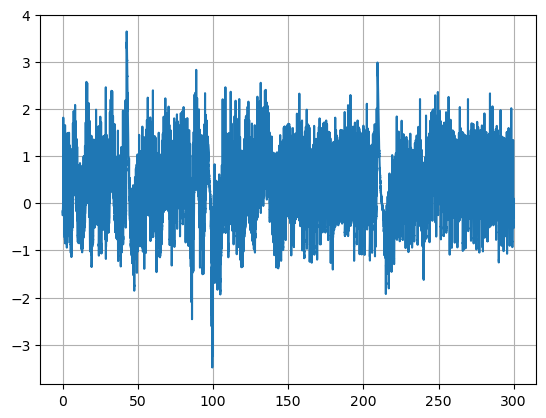

In [14]:
plt.plot(tvec, ecg)
plt.grid(True)

In [15]:
nfft = 4*len(ecg)
nfft

432000

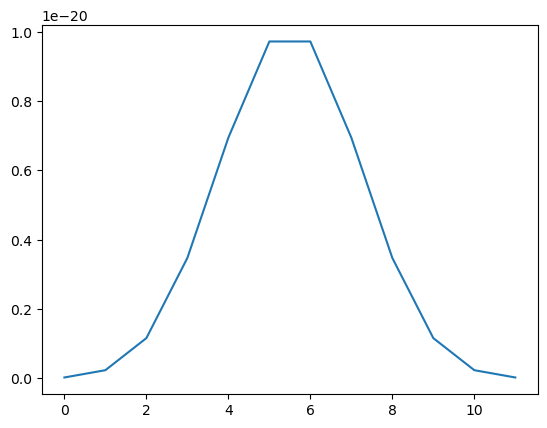

In [35]:
from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a
cutoff = 1.0
order = 11
b, a = butter_lowpass(cutoff, fs, order)
plt.plot(b)

In [37]:
def apply_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y
ecg_filtered = apply_lowpass_filter(ecg, cutoff, fs, order)
ecg_filtered[:10]

array([-5.15201797e-24, -1.17233718e-22, -1.33509622e-21, -1.01845797e-20,
       -5.87612998e-20, -2.74459321e-19, -1.08437776e-18, -3.73777974e-18,
       -1.15008983e-17, -3.21510147e-17])

In [22]:
Xk = np.fft.fftshift(np.fft.fft(ecg, nfft))
Xk_mag = 20.0*np.log10(np.abs(Xk))

In [39]:
Yk = np.fft.fftshift(np.fft.fft(ecg_filtered, nfft))
Yk_mag = 20.0*np.log10(np.abs(Yk))

In [43]:
Yk_mag[:5]

array([nan, nan, nan, nan, nan])

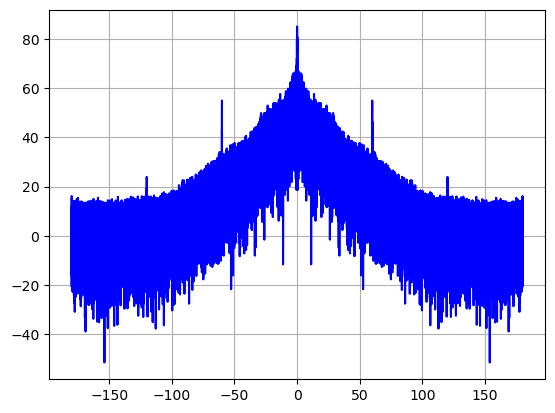

In [45]:
freqvec = np.array([(k-nfft/2)*fs/nfft for k in range(nfft)])
plt.plot(freqvec, Xk_mag, label="Unfiltered Signal", color="blue")
# plt.plot(freqvec, Yk_mag, label="Filtered Signal", color="black")
plt.grid(True)
# plt.xlim([0, 5])